This notebook will train an XGBoost regression model to predict dam fullness
you may not need to run this if you already have the model from the repo


In [38]:
# pip install bayesian-optimization

In [2]:
from datetime import datetime
import pickle
import json
import glob
import os

from sklearn.metrics import (
    mean_absolute_error,
    mean_tweedie_deviance,
    mean_absolute_percentage_error,
)
from xgboost import XGBRegressor
from bayes_opt import BayesianOptimization
import xgboost
import seaborn as sns

sns.set_theme(color_codes=True)
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
import scipy.stats
import matplotlib.pyplot as plt

In [3]:
# path to training and validation data
training_data_path = os.path.join(os.getcwd(), "data/dam forecast train.csv")

val_data_path = os.path.join(os.getcwd(), "data/dam forecast val.csv")

In [4]:
# set location to save model
model_folder = os.getcwd()
model_name = "dam_forecast_03-11-23.pkl"
model_path = os.path.join(model_folder, "data", model_name)
model_path

'/Users/Nick/Documents/Work code/Weather-to-water/data/dam_forecast_03-11-23.pkl'

In [5]:
# we limit the max dam size as large dams are note well represented in our dataset
max_value = 20000

In [6]:
# load up training data, do some cleaning/sorting
training_data = pd.read_csv(training_data_path)
training_data = training_data.reindex(sorted(training_data.columns), axis=1)
training_data = training_data[training_data["dam_area"] < max_value]
training_data.replace([np.inf, -np.inf], 0, inplace=True)
training_data.head()

,SRC_DATE,acq_date_dec,acq_month,acq_year,class,class_name,dam_area,file_name,geometry,rain_0_months before,...,tavg_1_months before,tavg_2_months before,tavg_3_months before,tavg_4_months before,tavg_5_months before,tavg_6_months before,tavg_7_months before,tavg_8_months before,tavg_9_months before,water_area
0,20191216,2019.923077,12,2019,2,no water,1499.986376,arcgisonline_13466_pred_and_score.tif,POINT (150.7703260923624 -34.49997476956882),2.762451,...,20.396746,17.926054,15.415278,12.961130,13.086934,13.189901,16.016296,18.968658,21.853695,0.000000
1,20191216,2019.923077,12,2019,2,no water,1957.925202,arcgisonline_19956_pred_and_score.tif,POINT (150.7609417292462 -34.5194085769909),3.197464,...,20.336300,17.855085,15.332343,12.882524,13.011043,13.112334,15.936459,18.891691,21.774044,0.000000
2,20191216,2019.923077,12,2019,2,no water,56.557682,arcgisonline_29686_pred_and_score.tif,POINT (150.7921407085229 -34.48640159069117),2.658848,...,20.390297,17.952702,15.478308,13.054444,13.186954,13.291353,16.112299,19.028639,21.890549,0.000000
3,20191216,2019.923077,12,2019,0,dam and water,620.839041,arcgisonline_2208_pred_and_score.tif,POINT (150.8273026231211 -34.59007854166663),4.103868,...,19.747135,17.428568,15.065031,12.862777,13.064048,13.170877,15.932156,18.648500,21.329342,69.919793
4,20191216,2019.923077,12,2019,0,dam and water,911.591665,arcgisonline_43254_pred_and_score.tif,POINT (150.8025877887565 -34.57963568981891),3.889048,...,20.026794,17.639698,15.219195,12.937696,13.106893,13.211027,16.005402,18.805094,21.575476,85.853539


In [7]:
# load up validation data and do some cleaning/sorting
val_data = pd.read_csv(val_data_path)
val_data = val_data.reindex(sorted(val_data.columns), axis=1)
val_data = val_data[val_data["dam_area"] < max_value]
val_data.replace([np.inf, -np.inf], 0, inplace=True)
val_data.head()

,SRC_DATE,acq_date_dec,acq_month,acq_year,class,class_name,dam_area,file_name,geometry,rain_0_months before,...,tavg_1_months before,tavg_2_months before,tavg_3_months before,tavg_4_months before,tavg_5_months before,tavg_6_months before,tavg_7_months before,tavg_8_months before,tavg_9_months before,water_area
0,20151012,2015.769231,10,2015,0,dam and water,1467.191148,arcgisonline_132898_pred_and_score.tif,POINT (117.3172965191077 -33.24564247144878),9.043823,...,12.835136,11.108263,10.531229,12.044368,12.067635,16.236391,20.395378,24.588543,23.805340,400.256079
1,20160808,2016.615385,8,2016,0,dam and water,7575.018970,arcgisonline_70618_pred_and_score.tif,POINT (152.9625759629707 -26.43549796464562),30.879414,...,16.208225,16.421938,19.850100,22.161938,24.166159,25.166771,24.075779,23.361519,23.210749,5781.220903
2,20150329,2015.230769,3,2015,0,dam and water,2028.126533,arcgisonline_84979_pred_and_score.tif,POINT (142.9804044837108 -37.77391478774938),22.954985,...,20.310444,18.668152,16.997301,15.661266,13.949310,11.053338,8.662997,8.203583,9.625609,581.212166
3,20151215,2015.923077,12,2015,0,dam and water,569.161178,arcgisonline_101081_pred_and_score.tif,POINT (145.618767566165 -38.4325091507143),37.716213,...,15.805417,15.925524,11.613432,9.590775,9.022965,10.216203,12.452333,14.021166,16.439243,317.463008
4,20160416,2016.307692,4,2016,0,dam and water,3367.296500,arcgisonline_125002_pred_and_score.tif,POINT (118.0078021793126 -30.57147183423009),31.052204,...,24.274788,26.393480,26.532434,24.433882,23.749607,21.477095,14.928035,12.299461,11.371953,508.559500


In [8]:
training_data.shape

(108847, 36)

In [9]:
val_data.shape

(12092, 36)

In [10]:
# set a list of columns to drop, the model will not see these
drop_list = [
    "water_area",
    "file_name",
    "SRC_DATE",
    "geometry",
    "acq_year",
    "acq_month",
    "acq_date_dec",
    "class",
    "class_name",
]

In [11]:
# remove the drop list and setup target df
train_X = training_data.drop(columns=drop_list)
train_y = training_data[["water_area"]]
print(train_y.head())
train_X.head()

   water_area
0    0.000000
1    0.000000
2    0.000000
3   69.919793
4   85.853539


,dam_area,rain_0_months before,rain_10_months before,rain_11_months before,rain_12_months before,rain_1_months before,rain_2_months before,rain_3_months before,rain_4_months before,rain_5_months before,...,tavg_12_months before,tavg_1_months before,tavg_2_months before,tavg_3_months before,tavg_4_months before,tavg_5_months before,tavg_6_months before,tavg_7_months before,tavg_8_months before,tavg_9_months before
0,1499.986376,2.762451,36.125671,71.728584,69.268257,18.543798,32.006516,61.439262,35.894455,16.539648,...,22.234226,20.396746,17.926054,15.415278,12.961130,13.086934,13.189901,16.016296,18.968658,21.853695
1,1957.925202,3.197464,38.361225,75.389587,73.195740,19.394297,34.531719,64.828262,38.369305,17.053242,...,22.165726,20.336300,17.855085,15.332343,12.882524,13.011043,13.112334,15.936459,18.891691,21.774044
2,56.557682,2.658848,35.916077,69.969917,66.735779,18.249218,31.475410,60.696507,35.672646,16.840359,...,22.226084,20.390297,17.952702,15.478308,13.054444,13.186954,13.291353,16.112299,19.028639,21.890549
3,620.839041,4.103868,46.451984,76.181908,72.046654,19.497202,38.455097,70.509048,42.860733,19.531702,...,21.477997,19.747135,17.428568,15.065031,12.862777,13.064048,13.170877,15.932156,18.648500,21.329342
4,911.591665,3.889048,44.183247,76.219666,72.164078,19.490854,37.583042,69.094116,42.032280,18.774553,...,21.803089,20.026794,17.639698,15.219195,12.937696,13.106893,13.211027,16.005402,18.805094,21.575476


In [12]:
# setup validation sets
val_X = val_data.drop(columns=drop_list)
val_y = val_data[["water_area"]].copy()
print(train_y.head())
print(train_X.shape)
train_X.head()

   water_area
0    0.000000
1    0.000000
2    0.000000
3   69.919793
4   85.853539
(108847, 27)


,dam_area,rain_0_months before,rain_10_months before,rain_11_months before,rain_12_months before,rain_1_months before,rain_2_months before,rain_3_months before,rain_4_months before,rain_5_months before,...,tavg_12_months before,tavg_1_months before,tavg_2_months before,tavg_3_months before,tavg_4_months before,tavg_5_months before,tavg_6_months before,tavg_7_months before,tavg_8_months before,tavg_9_months before
0,1499.986376,2.762451,36.125671,71.728584,69.268257,18.543798,32.006516,61.439262,35.894455,16.539648,...,22.234226,20.396746,17.926054,15.415278,12.961130,13.086934,13.189901,16.016296,18.968658,21.853695
1,1957.925202,3.197464,38.361225,75.389587,73.195740,19.394297,34.531719,64.828262,38.369305,17.053242,...,22.165726,20.336300,17.855085,15.332343,12.882524,13.011043,13.112334,15.936459,18.891691,21.774044
2,56.557682,2.658848,35.916077,69.969917,66.735779,18.249218,31.475410,60.696507,35.672646,16.840359,...,22.226084,20.390297,17.952702,15.478308,13.054444,13.186954,13.291353,16.112299,19.028639,21.890549
3,620.839041,4.103868,46.451984,76.181908,72.046654,19.497202,38.455097,70.509048,42.860733,19.531702,...,21.477997,19.747135,17.428568,15.065031,12.862777,13.064048,13.170877,15.932156,18.648500,21.329342
4,911.591665,3.889048,44.183247,76.219666,72.164078,19.490854,37.583042,69.094116,42.032280,18.774553,...,21.803089,20.026794,17.639698,15.219195,12.937696,13.106893,13.211027,16.005402,18.805094,21.575476


In [13]:
# save out metadata to json, this is usefull when running predictions
meta_dict = {
    "col_names": list(train_X.columns),
    "model_path": model_path,
    "creation_date": str(datetime.today().strftime("%Y-%m-%d")),
}

with open(model_path.replace(".pkl", ".json"), "w") as fp:
    json.dump(meta_dict, fp)

In [14]:
train_X.sample(frac=0.8)

,dam_area,rain_0_months before,rain_10_months before,rain_11_months before,rain_12_months before,rain_1_months before,rain_2_months before,rain_3_months before,rain_4_months before,rain_5_months before,...,tavg_12_months before,tavg_1_months before,tavg_2_months before,tavg_3_months before,tavg_4_months before,tavg_5_months before,tavg_6_months before,tavg_7_months before,tavg_8_months before,tavg_9_months before
93040,1062.388048,29.709293,16.270588,24.754423,32.396503,23.751997,22.018639,32.244858,41.743973,65.093727,...,16.843828,15.946771,14.179656,11.622314,9.196788,8.664608,10.119511,12.869140,14.591101,17.237612
93642,1977.080441,201.011215,136.621902,51.490974,32.713192,71.387138,8.917585,20.142603,267.224884,14.617042,...,22.041014,22.333006,19.610527,16.076038,15.016551,12.652367,14.324883,16.706148,20.979605,22.437868
6543,836.291730,41.001698,31.911509,28.662092,70.687790,27.681652,48.569286,65.978615,147.780502,76.209763,...,24.106916,22.266932,17.762611,13.322031,11.989165,9.488914,9.485485,9.412393,12.929668,17.473186
10479,4607.209450,37.853539,33.323757,24.530582,83.041306,37.495148,46.914608,75.094109,161.805908,80.068031,...,24.064148,22.307632,17.825373,13.169682,11.806444,9.390937,9.136136,9.305931,12.681993,17.503485
94597,2983.096852,4.676908,3.666122,0.410199,1.382765,63.724174,65.652939,39.174934,56.180485,68.086113,...,20.725267,18.655830,16.537745,13.543747,12.171913,10.635892,11.389657,14.206077,17.681898,20.996052
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2003,1241.606724,10.369360,54.515644,6.665363,12.106716,146.929535,23.979935,67.121300,106.055130,92.802536,...,20.778236,22.224253,23.321993,26.413027,23.258501,20.215956,17.823397,14.599283,12.088397,11.609908
48569,2376.887689,11.692733,9.621569,45.897022,0.534096,14.236906,50.556385,22.592264,66.790291,23.164917,...,20.473248,24.878101,25.308048,24.697826,21.280260,20.386524,12.104436,9.606523,8.132383,8.969941
91893,1891.221447,93.170235,93.137177,17.230621,17.177336,9.198551,1.296564,16.378967,58.011341,22.102760,...,26.205660,25.673622,21.219416,15.413925,11.526428,10.398180,11.766169,15.644429,19.467546,23.269522
73263,5313.528312,8.977778,4.179929,17.624628,11.254027,1.606855,40.711208,3.248338,52.030819,125.314018,...,18.607317,20.574549,28.824949,28.564152,28.971241,28.189838,29.462755,24.222776,18.631481,14.587440


In [15]:
model_path

'/Users/Nick/Documents/Work code/Weather-to-water/data/dam_forecast_03-11-23.pkl'

In [16]:
# func to train a model using variable inputs
def train_model(learning_rate, n_estimators, max_depth):
    n_estimators = round(n_estimators)
    max_depth = round(max_depth)

    xgb_reg = XGBRegressor(
        learning_rate=learning_rate,
        n_estimators=n_estimators,
        max_depth=max_depth,
        tree_method="hist",
        objective="reg:tweedie",
    )
    xgb_reg.fit(train_X, train_y, verbose=0)

    y_pred = xgb_reg.predict(val_X)
    y_pred = y_pred * (y_pred > 0)

    model_mean_error = mean_absolute_error(val_data["water_area"].to_numpy(), y_pred)

    return -model_mean_error

In [17]:
# set the bounds for optimization search
pbounds = {"learning_rate": (0.1, 0.5), "n_estimators": (10, 700), "max_depth": (1, 10)}

In [18]:
# setup optimizer
optimizer = BayesianOptimization(
    f=train_model,
    pbounds=pbounds,
    verbose=2,
    random_state=1,
)

In [19]:
# run optimizer
optimizer.maximize(
    init_points=15,
    n_iter=30,
)

|   iter    |  target   | learni... | max_depth | n_esti... |
-------------------------------------------------------------
| 1         | -948.7    | 0.2668    | 7.483     | 10.08     |
| 2         | -368.6    | 0.2209    | 2.321     | 73.71     |
| 3         | -336.1    | 0.1745    | 4.11      | 283.8     |
| 4         | -339.1    | 0.3155    | 4.773     | 482.8     |
| 5         | -443.2    | 0.1818    | 8.903     | 28.9      |
| 6         | -342.3    | 0.3682    | 4.756     | 395.5     |
| 7         | -337.6    | 0.1562    | 2.783     | 562.5     |
| 8         | -339.5    | 0.4873    | 3.821     | 487.7     |
| 9         | -354.7    | 0.4506    | 9.051     | 68.68     |
| 10        | -337.0    | 0.1156    | 2.528     | 615.9     |
| 11        | -330.2    | 0.1393    | 4.79      | 670.9     |
| 12        | -343.1    | 0.3133    | 7.227     | 227.7     |
| 13        | -351.5    | 0.3746    | 8.512     | 22.62     |
| 14        | -416.1    | 0.4001    | 9.9       | 526.2     |
| 15    

In [19]:
# show best vars
# best_pers = optimizer.max
# best_pers

In [20]:
def train_fin_model(learning_rate, n_estimators, max_depth):
    n_estimators = round(n_estimators)
    max_depth = round(max_depth)
    xgb_reg = XGBRegressor(
        learning_rate=learning_rate,
        n_estimators=n_estimators,
        max_depth=max_depth,
        tree_method="hist",
        objective="reg:tweedie",
    )
    xgb_reg.fit(train_X, train_y, eval_set=[(train_X, train_y)], verbose=0)

    return xgb_reg

In [21]:
model_count = 10

In [22]:
top_models = (
    pd.DataFrame(optimizer.res)
    .sort_values("target", ascending=[False])
    .head(model_count)
)
top_models

,target,params
10,-330.183377,"{'learning_rate': 0.13933873353322004, 'max_de..."
18,-335.499726,"{'learning_rate': 0.23539515374164766, 'max_de..."
2,-336.050459,"{'learning_rate': 0.17450408455106836, 'max_de..."
9,-336.965019,"{'learning_rate': 0.11562191329315295, 'max_de..."
6,-337.625215,"{'learning_rate': 0.15615477543809353, 'max_de..."
3,-339.053011,"{'learning_rate': 0.3155266936013428, 'max_dep..."
7,-339.545190,"{'learning_rate': 0.48730463028775906, 'max_de..."
14,-339.700124,"{'learning_rate': 0.2121775968257621, 'max_dep..."
26,-341.668318,"{'learning_rate': 0.35666949110479473, 'max_de..."
27,-341.683033,"{'learning_rate': 0.11684774080861456, 'max_de..."


In [23]:
models = []
for row, model_hyps in tqdm(top_models.iterrows(), total=model_count):
    models.append(
        {"model_number": str(row), "model": train_fin_model(**model_hyps["params"])}
    )

  0%|          | 0/10 [00:00<?, ?it/s]

In [24]:
preds = pd.DataFrame()
for model in models:
    y_pred = model["model"].predict(val_X)
    y_pred = y_pred * (y_pred > 0)
    preds[model["model_number"]] = y_pred

In [25]:
preds

,10,18,2,9,6,3,7,14,26,27
0,281.160339,277.440247,301.291962,306.310974,298.882721,249.248581,278.925781,267.983307,283.419678,293.763489
1,4029.106934,4159.641602,4126.700684,4155.320312,4082.592285,3954.449219,4082.105713,4260.218262,4592.108398,3851.345703
2,446.247162,524.589539,510.135498,560.031189,554.614624,452.664368,473.938232,516.046204,427.538544,481.904877
3,229.985092,217.700241,223.770432,233.793274,224.572449,225.901321,251.515457,219.656097,246.464005,219.431854
4,962.536682,883.213074,976.700500,876.307678,880.358521,798.219788,1219.893433,994.228943,1159.664795,1059.297852
...,...,...,...,...,...,...,...,...,...,...
12087,3923.656738,4288.307617,3999.853516,4130.614258,3869.632324,4460.363770,4306.623535,4142.287109,4368.510254,3887.186523
12088,228.935806,208.910736,206.675827,208.682831,194.472610,211.897049,234.071915,234.523499,224.902847,224.161194
12089,1391.895752,1302.858032,1545.041992,1387.211182,1528.172119,1344.481812,1009.834778,1456.985474,1410.848267,1344.263184
12090,1266.381592,1177.152588,1183.870850,1249.115967,1291.835449,1326.339111,1309.827759,1336.246582,1304.624146,1227.649170


In [26]:
val_y["preds"] = preds.mean(axis=1).to_list()

In [27]:
val_y

,water_area,preds
0,400.256079,283.842712
1,5781.220903,4129.358398
2,581.212166,494.770996
3,317.463008,229.279053
4,508.559500,981.042114
...,...,...
12230,5955.113008,4137.703613
12231,106.330725,217.723434
12232,2320.997848,1372.159180
12233,1341.055972,1267.304321


In [28]:
val_y.to_csv("data/dam forecast val vs pred.csv")

[(0.0, 20000.0)]

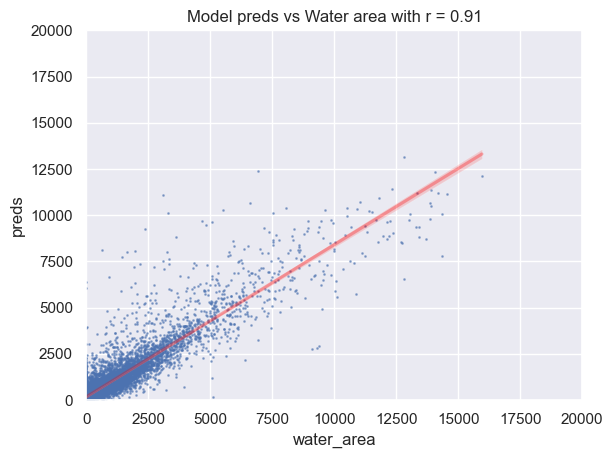

In [29]:
# plot up validation data preds vs measured values
ax = sns.regplot(
    x="water_area",
    y="preds",
    data=val_y,
    scatter_kws={"s": 1, "alpha": 0.5},
    line_kws={"color": "red", "alpha": 0.3},
)

# Calculate the correlation coefficient (r value)
r_value, p_value = scipy.stats.pearsonr(val_y["water_area"], val_y["preds"])
plt.title(f"Model preds vs Water area with r = {r_value:.2f}")

sns.set(rc={"figure.figsize": (8, 8)})
ax.set(ylim=(0, max_value))
ax.set(xlim=(0, max_value))

In [30]:
# use numpy to calc the line of best fit equation
# note this this looks much better than the scaled factor above
grad, y_intersect = np.polyfit(val_y["water_area"], val_y["preds"], 1)
grad, y_intersect

(0.8237240778293771, 168.18268868120896)

In [31]:
# significant improvement from scaled factor above
model_mae = mean_absolute_error(val_y["water_area"], val_y["preds"])
model_mae

328.15003347234295

In [32]:
# mean model error percent
model_mae / val_y["water_area"].mean()

0.32321569755843726

In [33]:
# mape = np.mean(np.abs(val_y['water_area'] - val_y['preds'])/val_y['preds'])*100
# mape

In [34]:
model_improvment = 1 - (model_mae / 466.89)
print(f"the model is {round(model_improvment*100)}% better than the scaled dam area")

the model is 30% better than the scaled dam area


In [35]:
model_improvment = 1 - (model_mae / 885.85)
print(
    f"the model is {round(model_improvment*100)}% better than always guessing water area mean"
)

the model is 63% better than always guessing water area mean


In [36]:
# save model to disk
# pickle.dump(xgb_reg, open(model_path, "wb"))
pickle.dump(models, open(model_path, "wb"))

In [37]:
model_path

'/Users/Nick/Documents/Work code/Weather-to-water/data/dam_forecast_03-11-23.pkl'